In [1]:
%pylab inline
numpy.random.seed(0)

import seaborn; seaborn.set_style('whitegrid')
from tqdm import tqdm_notebook as tqdm

Populating the interactive namespace from numpy and matplotlib


## 1. Submodular Selection
Author: Jacob Schreiber <jmschreiber91@gmail.com>

As an increasing amount of data in the world has enabled increasingly complex machine learning models that perform tasks like translate text between languages, classify objects in videos, and enable precision medicine. However, training these models comes at an increased computational cost. While some of this cost can be mitigated through parallelized implementations and the utilization of GPUs, this hardware costs money that individuals or small organizations don't always have.

Submodular selection is one approach to decreasing the computational cost of training complex models through the selection of a representative subset of the data to instead train models on. This subset is selected in a manner that reduces redundancy in the data set and increased the diversity of the chosen examples. Correspondingly, the models that are trained using this subset almost always outperform random subsets and frequently can achieve optimal performance in only a fraction of the samples.

Briely, the way that submodular search works is that one defines a function that returns approximately how useful a set of samples are, and then greedily optimizes that function. Optimally, this function would be the performance by some machine learning model. One would then be able to identify a minimal set that yielded top performance, where adding additional examples didn't improve the performance of the model. However, because this would require retraining a model over and over again, frequently an approximation of model performance is instead used.

apricot implements two forms of submodular selection: feature based functions and facility location functions. These functions will be described in more detail below, but feature based functions force a diversity of feature values by modeling the saturation of each feature in the growing subset, whereas facility location functions force diversity in the original space by measuring the distance from all points to their nearest representative.

### Feature Based Submodularity

A problem with some submodular functions is that they do not scale well across massive data sets. For example, the facility location function first involves calculating some pairwise information across the data set, and second involves recalculating this pairwise measurement each time a sample is potentially added to the growing set. While optimizations exist that can greatly speed this up when compared to a naive implementation, it still can be prohibitively slow in some cases.

A different type of submodular function, called a "feature based" function, does not involve calculating pairwise information and is much more scalable to large data sets. These functions involve calculating how "saturated" a particular feature is and preferentially selecting samples that have large feature values that have not yet been seen. These function takes the following form:

\begin{equation}
f(X) = \sum\limits_{u \in U} w_{u} \phi_{u} \left( \sum\limits_{x \in X} m_{u}(x) \right)
\end{equation}

In this equation, $U$ refers to all features, or dimensions, of a sample, and $u$ refers to a specific feature. $X$ refers to the original data set that we are selecting from and $x$ refers to a single sample from that data set. $w$ is a vector of weights that indicate how important each feature is, with $w_{u}$ being a scalar referring to how important feature $u$ is. Frequently these weights are uniform. $\phi$ refers to a set of saturating functions, such as $sqrt(X)$ or $log(X + 1)$ that take some 


Feature based functions perform best when the value of each feature corresponds roughly to some notion of how important it is rather than being an arbitrary value. For example, when considering audio data, a spike in noise indicates that something is happening in an otherwise silent background, and when considering financial portfolios the more money a person has in a stock or fund, the more important that fund is for them. Examples of features where feature based functions are not likely to work well on are those without this notion, including categorical variables such as car color or bimodally distributed variables.

The reason that feature based funtions don't perform well when thre is no notion of importance can easily be visualized by looking at two Gaussian blobs. One might expect that a good summarization function would select a similar number of points from each blob, perhaps near the boundary between the two. Let's see what a feature based function does.

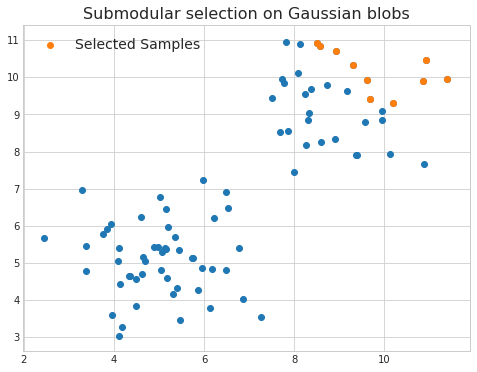

In [2]:
from apricot import FeatureBasedSelection

X = numpy.concatenate([numpy.random.normal(5, 1, size=(50, 2)), numpy.random.normal(9, 1, size=(35, 2))])
Xi = FeatureBasedSelection(10).fit_transform(X)

plt.figure(figsize=(8, 6))
plt.title("Submodular selection on Gaussian blobs", fontsize=16)
plt.scatter(X[:,0], X[:,1])
plt.scatter(Xi[:,0], Xi[:,1], label="Selected Samples")
plt.legend(fontsize=14)
plt.show()

The feature based selection chooses those samples with the highest absolute magnitude. This is not surprising because the function is trying to maximize the sum of the saturated values over each feature. You can maximize this value by always selecting the biggest values.

#### 20 newsgroups Data Set

The setting in which feature based functions perform the best is when the value of the feature corresponds to a quantity or a significance, where a higher value of that feature corresponds to having a large amount of that feature. A natural example of this is using word counts or tf-idf to represent sentences where each feature is a word. Let's see that in action here with an example from the 20newsgroups data set.

In [3]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

cats = ('sci.med', 'sci.space')
stop = ('headers', 'footers', 'quotes')

train_data = fetch_20newsgroups(subset='train', categories=cats, remove=stop)
test_data = fetch_20newsgroups(subset='test', categories=cats, remove=stop)

X_train, y_train = train_data.data, train_data.target
X_test, y_test = test_data.data, test_data.target

vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)

X_train = vectorizer.fit_transform(X_train).todense()
X_test = vectorizer.transform(X_test).todense()

X_train.shape, X_test.shape

((1187, 1000), (790, 1000))

We've downloading 1,187 samples for our training set and 790 for our test set. This is just a toy example and so training on the entire training set is feasible, but let's see how good models trained using small subsets can perform when using random selection versus using a feature based function. We'll also perform our random selection 20 times, showing the best, worst, and average performance across the 20 times.

In [4]:
from sklearn.linear_model import LogisticRegressionCV

submodular_accuracy, random_accuracy = [], []

selection = FeatureBasedSelection(1000)
selection.fit(X_train)

numpy.random.seed(0)
random_idxs = []
for i in range(20):
    idxs = numpy.arange(X_train.shape[0])
    numpy.random.shuffle(idxs)
    random_idxs.append(idxs)

x = [20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
    
for n in tqdm(x):
    Xi, yi = selection.transform(X_train, y_train)
    Xi, yi = Xi[:n], yi[:n]

    model = LogisticRegressionCV().fit(Xi, yi)
    submodular_accuracy.append(model.score(X_test, y_test))

    accs = []
    for i in range(20):
        idx = random_idxs[i][:n]
        Xi, yi = X_train[idx], y_train[idx]

        model = LogisticRegressionCV().fit(Xi, yi)
        accs.append(model.score(X_test, y_test))
        
    random_accuracy.append(accs)

random_accuracy = numpy.array(random_accuracy)

A Jupyter Widget

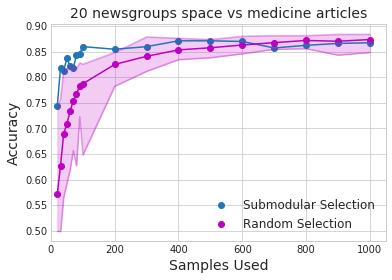

In [5]:
plt.title("20 newsgroups space vs medicine articles", fontsize=14)
plt.scatter(x, submodular_accuracy, label="Submodular Selection")
plt.scatter(x, random_accuracy.mean(axis=1), color='m', label="Random Selection")

plt.plot(x, submodular_accuracy)
plt.plot(x, random_accuracy.mean(axis=1), color='m')
plt.plot(x, random_accuracy.min(axis=1), alpha=0.3, color='m')
plt.plot(x, random_accuracy.max(axis=1), alpha=0.3, color='m')

plt.fill_between(x, random_accuracy.min(axis=1), random_accuracy.max(axis=1), color='m', alpha=0.2)
plt.xlabel("Samples Used", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.legend(fontsize=12)
plt.xlim(0, 1050)
plt.savefig("img/20newsgroups.png")
plt.show()

It looks like submodular selection through a feature based method distinctly outperforms using random selection for a small number of samples. Using only 100 samples one can achieve high accuracy (0.859 versus 0.870 best accuracy).  

### Facility Location

Another approach to subset selection comes in the form of facility location functions. These functions operate primarily on pairwise similarity scores between two samples rather than their feature values directly. Because of this, the feature values of the samples can be negative as long as the similarity score is strictly non-negative. 

Facility location functions are named because an early use was in placing facilities for companies, such as distribution warehouses or stores. The question was, "if we have facilities at some locations, what is the next best location to put a facility?" The answer is typically an underserved region. This results in a greedy selection algorithm where the first facility is at a central location and then subsequent facilities are spaced out based on where locations exist.

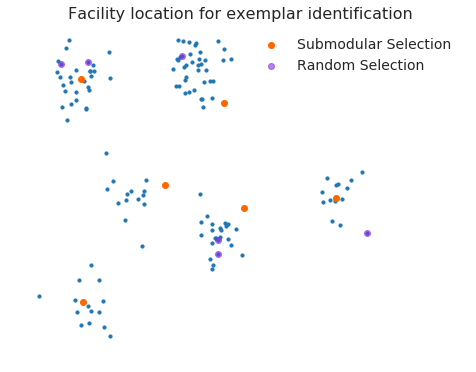

In [6]:
from apricot import FacilityLocationSelection

numpy.random.seed(0)
X = numpy.concatenate([numpy.random.normal((1, 1), 0.5, size=(15, 2)),
                       numpy.random.normal((6, 3), 0.5, size=(25, 2)),
                       numpy.random.normal((5, 7), 0.5, size=(40, 2)),
                       numpy.random.normal((1, 7), 0.5, size=(30, 2)),
                       numpy.random.normal((10, 4), 0.5, size=(15, 2)),
                       numpy.random.normal((3, 4), 0.5, size=(15, 2))])

Xi = FacilityLocationSelection(6, 'euclidean').fit_transform(X)
Xr = numpy.random.choice(numpy.arange(X.shape[0]), size=6)
Xr = X[Xr]

plt.figure(figsize=(8, 6))
plt.title("Facility location for exemplar identification", fontsize=16)
plt.scatter(X[:,0], X[:,1], s=10)
plt.scatter(Xi[:,0], Xi[:,1], color="#FF6600", label="Submodular Selection")
plt.scatter(Xr[:,0], Xr[:,1], color="#8A2BE2", label="Random Selection", alpha=0.6)
plt.legend(fontsize=14, loc=1)
plt.xlim(-1, 14)
plt.axis('off')
plt.show()

In this example an example of selecting representative points from six clusters using either a facility location function or random selection. You can see immediately that the points are more representative of the total space than a feature based function would be. A random selection of points is unlikely to sample each of the clusters only once, and this skew worsens with the skew of samples per cluster, whereas a facility location function is more stable towards that. An animation of the selection process can give some insight into how it works.

<img src="img/facilitylocation.gif">

The first selected sample is at a central location because, as a facility like a store, it would serve all of the locations the best. The second location is near the largest cluster of points. The third location is near another cluster of points but more to the right. At this point something interesting happens: the next selected samples seem to be central to the cluster they're selected in. Essentially, once the space is sparsely covered then the next selected sample can focus on serving a local neighborhood.

Facility location can be thought of as a greedy version of k-means clustering. K-means is an iterative procedure that would've resulted in the centroids lying at the center of each of the clusters above. However, it would be significantly more time intensive to calculate these. Correspondingly, facility location functions are a good initialization for the k-means algorithm and is known as k-means++ in that context.

#### Digits Data Set

We can use facility location for sample selection for machine learning algorithms as well. In fact, it works better than feature based methods in cases where the features do not have the nice properties seen before. Let's load up the digits data set. A feature based function would try to select samples that had a diversity of high pixel values. That's not exactly what we want because the digit can exist in several places in the image with different sizes and thicknesses.

In [7]:
from sklearn.datasets import load_digits

data = load_digits()
X, y = data.data, data.target 

idx = numpy.arange(X.shape[0])
numpy.random.shuffle(idx)

X, y = X[idx], y[idx]
X_train, y_train = X[:1250], y[:1250]
X_test, y_test = X[1250:], y[1250:]
X_train.shape, X_test.shape

((1250, 64), (547, 64))

Let's take 1,250 samples for the training set and 547 samples for the test set. We can try using a facility location function on the data that calculates the euclidean distance between samples and compare that both to random selection and to using a feature based selection algorithm. 

In [8]:
selector = FacilityLocationSelection(X_train.shape[0], 'euclidean', verbose=True)
selector.fit(X_train)
r1 = selector.ranking

selector2 = FeatureBasedSelection(X_train.shape[0], verbose=True)
selector2.fit(X_train)
r2 = selector2.ranking

100%|██████████| 1250/1250 [00:00<00:00, 2020.47it/s]


Now let's try training logistic regression models like before in these settings.

In [9]:
from sklearn.linear_model import LogisticRegression

numpy.random.seed(0)
random_idxs = []
for i in range(20):
    idxs = numpy.arange(X_train.shape[0])
    numpy.random.shuffle(idxs)
    random_idxs.append(idxs)

fl_acc, fb_acc, random_acc = [], [], []
n_samples = range(25, 251, 25) + range(300, 1251, 100)

for n in tqdm(n_samples):
    Xi, yi = X_train[r1[:n]], y_train[r1[:n]]
    model = LogisticRegression().fit(Xi, yi)
    fl_acc.append(model.score(X_test, y_test))
 
    Xi, yi = X_train[r2[:n]], y_train[r2[:n]]
    model = LogisticRegression().fit(Xi, yi)
    fb_acc.append(model.score(X_test, y_test))

    accs = []
    for i in range(20):
        idx = random_idxs[i][:n]
        Xi, yi = X_train[idx], y_train[idx]

        model = LogisticRegression().fit(Xi, yi)
        accs.append(model.score(X_test, y_test))
        
    random_acc.append(accs)

random_acc = numpy.array(random_acc)

A Jupyter Widget

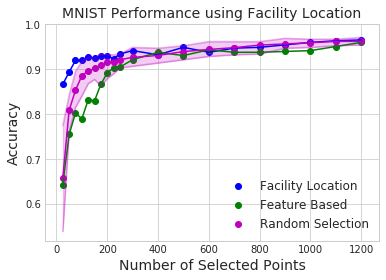

In [10]:
plt.title("MNIST Performance using Facility Location", fontsize=14)
plt.scatter(n_samples, fl_acc, c='b', label="Facility Location")
plt.scatter(n_samples, fb_acc, c='g', label="Feature Based")
plt.scatter(n_samples, random_acc.mean(axis=1), color='m', label="Random Selection")

plt.plot(n_samples, fl_acc, c='b')
plt.plot(n_samples, fb_acc, c='g')
plt.plot(n_samples, random_acc.mean(axis=1), color='m')
plt.plot(n_samples, random_acc.min(axis=1), alpha=0.3, color='m')
plt.plot(n_samples, random_acc.max(axis=1), alpha=0.3, color='m')

plt.fill_between(n_samples, random_acc.min(axis=1), random_acc.max(axis=1), color='m', alpha=0.2)
plt.xlabel("Number of Selected Points", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.legend(fontsize=12)
plt.show()

It looks like the facility location function outperforms both the feature based function and the random selection. Similar to the case of the feature based function before the model performance appears to saturate with just a small percentage of the samples. In fact, the feature based function performs worse than the random selection. This is not surprising in the case where optimizing a diversity of features irrespective of the structure of the features may not be the best idea.